## Import Statements

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import json

from os.path import join
from src.data_loading import load_physionet_dataset, prepare_training_data


## Data Loading

We load the Phyionet dataset using the given helper function. Then we investigate the information in the dataset and check how many recordings are associated with the patients. 


<class 'pandas.core.frame.DataFrame'>
Index: 21396 entries, 1 to 21837
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21396 non-null  float64
 1   age                           21396 non-null  float64
 2   sex                           21396 non-null  int64  
 3   height                        6919 non-null   float64
 4   weight                        9367 non-null   float64
 5   nurse                         19949 non-null  float64
 6   site                          21379 non-null  float64
 7   device                        21396 non-null  object 
 8   recording_date                21396 non-null  object 
 9   report                        21396 non-null  object 
 10  scp_codes                     21396 non-null  object 
 11  heart_axis                    13228 non-null  object 
 12  infarction_stadium1           5603 non-null   object 
 13  infarc

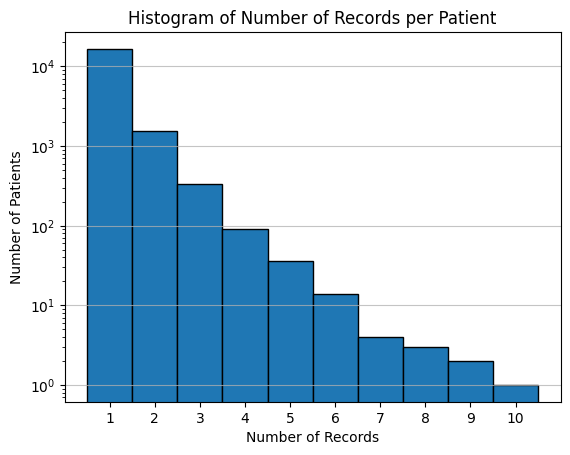

In [34]:
path_to_data = "../data/physionet.org/files/ptb-xl/1.0.2/"

df = load_physionet_dataset(path=path_to_data)
print(df.info())

patient_record_counts = df['patient_id'].value_counts()

plt.yscale('log')
plt.hist(patient_record_counts, bins=range(1, patient_record_counts.max() + 2), edgecolor='black', align='left')
plt.title('Histogram of Number of Records per Patient')
plt.xlabel('Number of Records')
plt.ylabel('Number of Patients')
plt.xticks(range(1, patient_record_counts.max() + 1))
plt.grid(axis='y', alpha=0.75)
plt.show()

## Patient Analysis

We now try to understand the dataset distribution by analyzing patient statistics

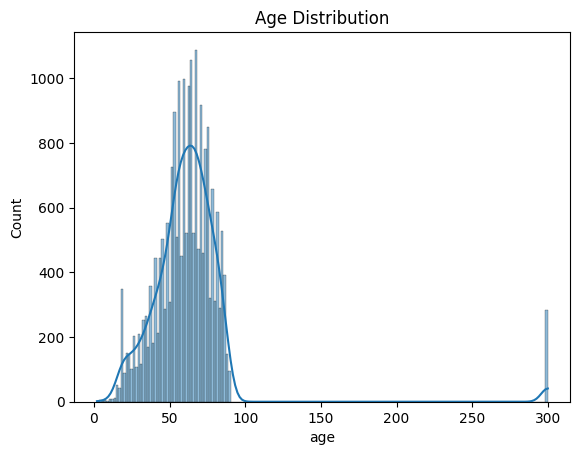

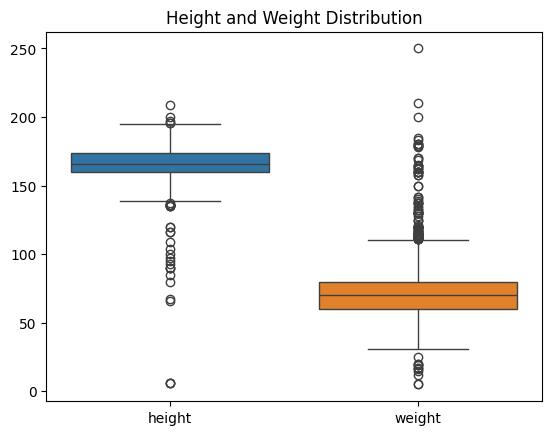

In [35]:
sns.histplot(df['age'], kde=True)
plt.title('Age Distribution')
plt.show()

sns.boxplot(data=df[['height', 'weight']])
plt.title('Height and Weight Distribution')
plt.show()

## Data Origin

We now try to analyze the diversity of the dataset by investigating the origin, such as devices, and sites

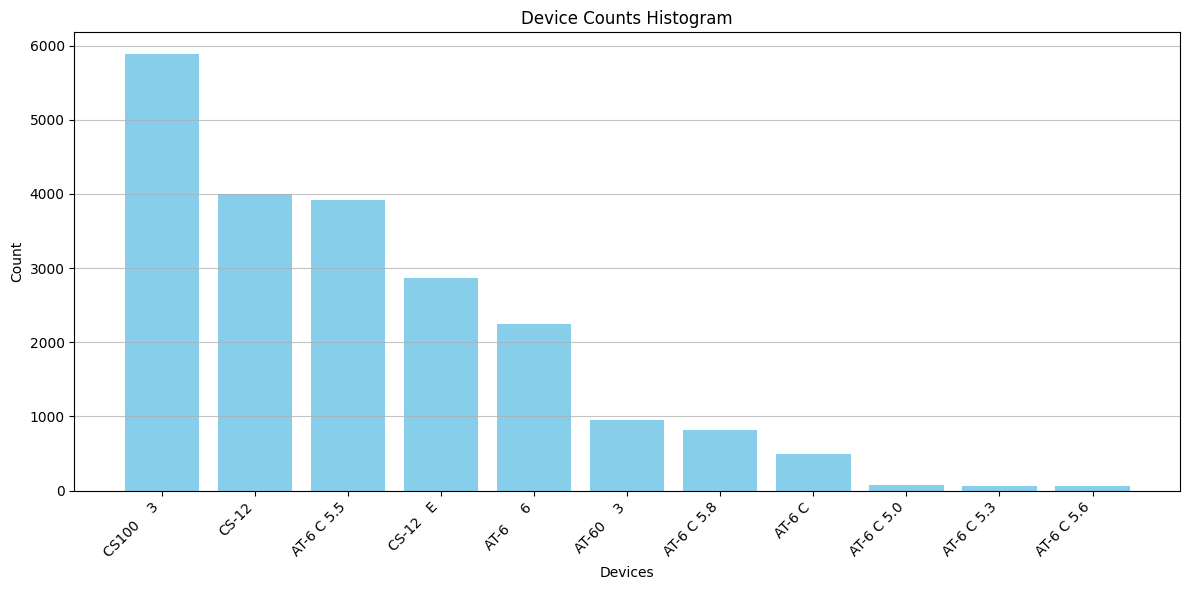

In [36]:
device_counts = df['device'].value_counts()

plt.figure(figsize=(12, 6))
plt.bar(device_counts.index, device_counts.values, color='skyblue')
plt.title('Device Counts Histogram')
plt.xlabel('Devices')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate device names for better readability
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()  # Adjust layout to fit labels
plt.show()


## Data Integrity

Now we check the data for potential errors, assuming that the values in the columns 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker' are regarded as problematic samples as they might introduce noise into the model. We define good data points as values without any known errors.

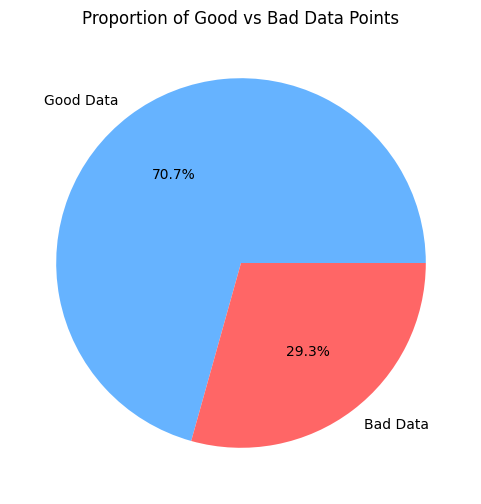

/var/folders/f3/sjrhhs9n24n82n8gvmbk37y00000gn/T/ipykernel_2924/522399598.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=error_counts.index, y=error_counts.values, palette="Reds")


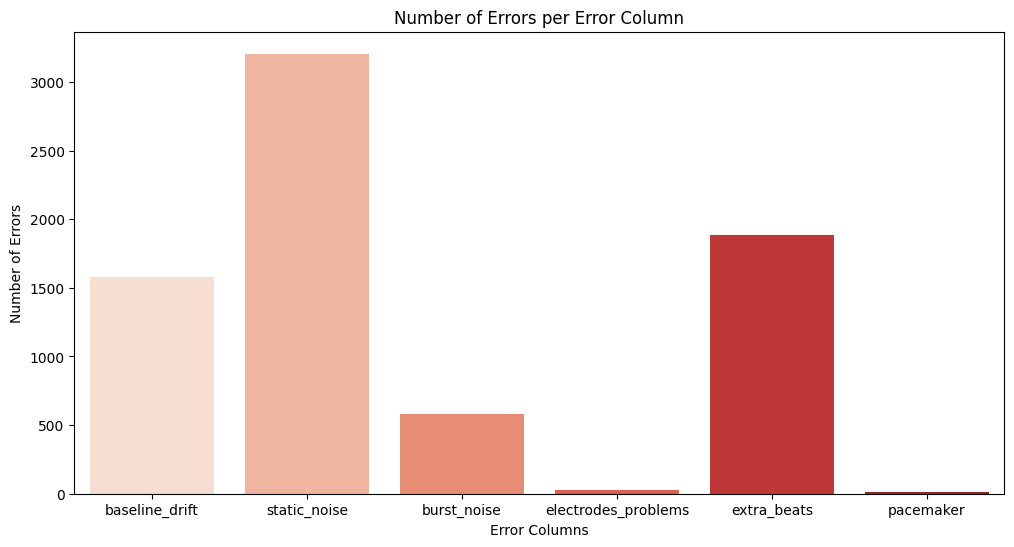

In [37]:
error_columns = ['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker']

# 1. Create a new column 'has_error' which is True if any of the six error columns are not NaN
df['has_error'] = df[error_columns].notna().any(axis=1)

# 2. Plot the proportion of good (NaN in all error columns) vs bad data points
good_data_count = df['has_error'].value_counts()

# Plotting the proportion
plt.figure(figsize=(6, 6))
good_data_count.plot.pie(labels=['Good Data', 'Bad Data'], autopct='%1.1f%%', colors=['#66b3ff', '#ff6666'])
plt.title('Proportion of Good vs Bad Data Points')
plt.ylabel('')
plt.show()

error_counts = df[error_columns].notna().sum()

plt.figure(figsize=(12, 6))
sns.barplot(x=error_counts.index, y=error_counts.values, palette="Reds")
plt.title('Number of Errors per Error Column')
plt.xlabel('Error Columns')
plt.ylabel('Number of Errors')
plt.show()

## Data Cleaning and Export

In this part, we remove problematic features within the data. Otherwise, for this iteration and given the time constraints, we utilize the data available, including potentially problematic samples for training.

- Age outliers
- Error values
- Ambigious diagnostic superclass values


In [55]:
# Remove samples with errors
output_path = "../data/processed"
os.makedirs(output_path, exist_ok=True)
print(df.shape)
print(df["diagnostic_superclass"])

df_clean = df[df['age'] <= 100]  # Remove outlier age
df_clean = df_clean[df_clean['has_error'] == False]  # Remove samples with potential errors
df_clean = df_clean[~df_clean["diagnostic_superclass"].apply(lambda x: "NORM" in x and len(x) > 1)]  # Remove label columns where NORM is connected to other Codes

# Add ground truth labels
df_clean["ground_truth"] = df_clean['diagnostic_superclass'].apply(lambda x: 0 if "NORM" in x else 1)
df_clean.to_csv(join(output_path, "y.csv"))

print(df_clean["ground_truth"])
print(df_clean.shape)


(21396, 45)
ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21396, dtype: object
ecg_id
2        0
3        0
7        0
10       0
12       0
        ..
21823    0
21824    1
21830    0
21831    0
21832    1
Name: ground_truth, Length: 14595, dtype: int64
(14595, 46)


## Exporting the Training Data (Takes Processing Time)

This next step is collecting the training data and storing it in a binary numpy value. Throughout our experiments, we use the downsamples 100 Hz ECG data to simplify calculations.

In [32]:
# Export the training data
X, y = prepare_training_data(path_to_data, df_clean, 100)
np.save(join(output_path, 'X.npy'), X)
